# Magnetic Field Inference from Spectropolarimetric Data Using the Weak Field Approximation

## Abstract

We present an analysis of photospheric magnetic fields in a solar active region using spectropolarimetric observations from Hinode/SOT-SP in the Fe I lines at 630.15 nm and 630.25 nm. The magnetic field strength and orientation are inferred using the Weak Field Approximation (WFA) under conditions of unresolved Zeeman splitting. Our methodology employs Gaussian curve fitting for wavelength calibration, median-based statistics for polarization mapping, and Monte Carlo simulation for uncertainty quantification. Noise levels are characterized using the Median Absolute Deviation (MAD) from continuum windows. The WFA is implemented with a matrix formulation that enables systematic error propagation and bias correction. We derive maps of the line-of-sight magnetic field ($B_{\parallel}$), transverse field ($B_{\perp}$), and field azimuth ($\chi_B$) with associated uncertainties, providing a comprehensive characterization of the magnetic field configuration in the observed solar structure.

## 1. Introduction

Solar magnetic fields are the fundamental drivers of solar activity, governing phenomena ranging from small-scale flux emergence to large-scale coronal mass ejections and flares. Understanding the three-dimensional structure of magnetic fields in the solar photosphere is essential for modeling energy transport, plasma dynamics, and magnetic reconnection events that power solar eruptive phenomena. Active region loops, such as those analyzed in this study, represent locations where magnetic flux emerges from below the photosphere and extends into the corona. These structures provide critical insights into the topology and evolution of solar magnetic fields, which are necessary for constraining magnetohydrodynamic models of the solar atmosphere, understanding energy storage and release mechanisms, and predicting space weather events.

Spectropolarimetry measures the four Stokes parameters (I, Q, U, V) across spectral lines, encoding information about magnetic fields through the Zeeman effect. The Weak Field Approximation is particularly useful when Zeeman splitting remains unresolved in the observations, which is common in quiet Sun and moderate field strength regions with magnetic fields below approximately 1500 Gauss. Under the WFA, circular polarization (Stokes V) is proportional to the line-of-sight magnetic field component, while linear polarization (Stokes Q and U) is proportional to the square of the transverse field component. The field azimuth is encoded in the ratio of Q to U. The Fe I lines at 630.15 nm and 630.25 nm are ideal for photospheric diagnostics due to their sensitivity to magnetic fields, with Landé factors of 1.67 and 2.5 respectively, and minimal blending with other spectral features.

## 2. Data

The observations analyzed in this work were obtained with the Hinode Solar Optical Telescope Spectropolarimeter (SOT/SP). The dataset consists of a five-dimensional data cube containing the four Stokes parameters (I, Q, U, V) as functions of time, two spatial dimensions (x, y), and wavelength (λ). The spectral coverage includes the magnetically sensitive Fe I lines at 6301.5 Å and 6302.5 Å. These iron lines are formed in the photosphere and exhibit Zeeman splitting in the presence of magnetic fields, making them ideal diagnostics for inferring magnetic field strength and orientation.

The physical constants employed in this analysis are the WFA constant $C_0 = 4.67 \times 10^{-13}\,\mathrm{G^{-1}\,Å^{-1}}$, the effective Landé factors $g_{\text{eff}} = [1.67, 2.5]$ for the two lines, and the mean Landé factors $\bar{g} = [2.51, 6.25]$. The reference wavelengths for calibration are 630.15008 nm and 630.24932 nm. The observations target a solar active region loop structure, providing temporal and spatial coverage of the evolving magnetic field configuration.

## 3. Methodology

This analysis employs several robust computational techniques designed to provide accurate field inference with well-characterized uncertainties. Wavelength calibration is performed by fitting Gaussian profiles to the absorption line minima using least-squares optimization (`scipy.optimize.curve_fit`), which provides sub-pixel precision in determining line centers while being robust to noise. Polarization mapping constructs spatial maps using median-based statistics and adaptive peak finding, reducing sensitivity to outliers in the data. Monte Carlo simulation employs synthetic data generation with known magnetic field parameters to validate the WFA inference and characterize systematic biases introduced by noise. Noise characterization uses the Median Absolute Deviation from continuum spectral windows as estimator less affected by outliers than standard deviation. The WFA is implemented in a matrix formulation that enables systematic error propagation and explicit bias correction for the transverse field component.

The analysis workflow consists of five main stages. First, wavelength calibration is performed by fitting Gaussian profiles to each spectral half to locate the line centers of both Fe I lines with sub-pixel precision, followed by construction of a linear wavelength axis. Second, polarization maps are generated by applying spectral aggregation methods to extract representative Stokes values for each spatial pixel across time. Third, Monte Carlo noise analysis is conducted using synthetic profiles with known magnetic field parameters to validate the WFA inference and characterize systematic biases. Fourth, polarimetric noise levels are estimated from line-free continuum windows using the MAD estimator. Fifth, the WFA equations are applied to the observed data to infer the line-of-sight magnetic field, transverse field strength, and field azimuth, with propagated uncertainties for each quantity.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
from scipy import signal
from scipy.optimize import curve_fit
from scipy.stats import median_abs_deviation
from astropy.io import fits
from matplotlib.patches import Circle
from tqdm import tqdm

plt.rcParams.update({
    'figure.dpi': 100,
    'font.size': 10,
    'axes.grid': False,
    'axes.linewidth': 1.0,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.top': False,
    'ytick.right': False,
})

# Constants
REF_WAVELENGTHS = np.array([630.15008, 630.24932])  # nm
G_EFF = np.array([1.66667, 2.5])  # Effective Landé factors
GBAR = np.array([2.51667, 6.25])  # Mean Landé factors
C0 = 4.6686e-13  # WFA constant (G^-1 Å^-1)

# Data files
FILE_LOOP = 'datos_loop.fits'
FILE_SINT = 'datos_sint.fits'
FILE_ATLAS = 'atlas_6301_6302.fits'

# 4.1. Wavelength Calibration via Gaussian Fitting

We use Gaussian curve fitting to determine line positions with sub-pixel precision.

Spectral dimension: 112 pixels


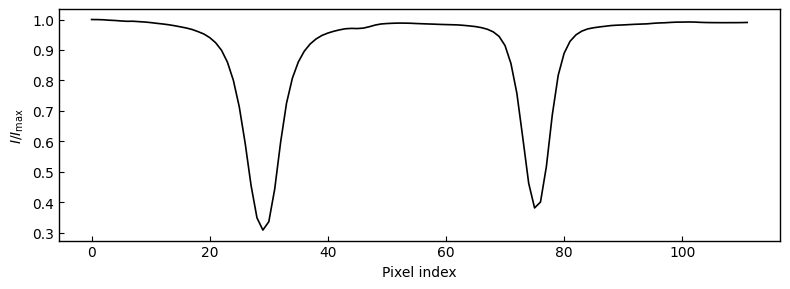

In [2]:
# Load and prepare average intensity profile
with fits.open(FILE_LOOP) as hdul:
    # Sum over spatial dimensions
    intensity_avg = np.median(hdul[0].data[0, :, :, :, :], axis=(0, 1, 2))

# Normalize
intensity_avg /= np.max(intensity_avg)
n_spec = intensity_avg.size
pixel_indices = np.arange(n_spec)

print(f'Spectral dimension: {n_spec} pixels')

# Visualize
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(pixel_indices, intensity_avg, 'k-', lw=1.2)
ax.set_xlabel('Pixel index')
ax.set_ylabel(r'$I / I_{\mathrm{max}}$')
plt.tight_layout()
plt.show()

### Line center detection via Gaussian fitting

We fit a Gaussian profile to each absorption line to determine the center with sub-pixel precision.

Line centers (pixels): [28.99949364 75.27180494]


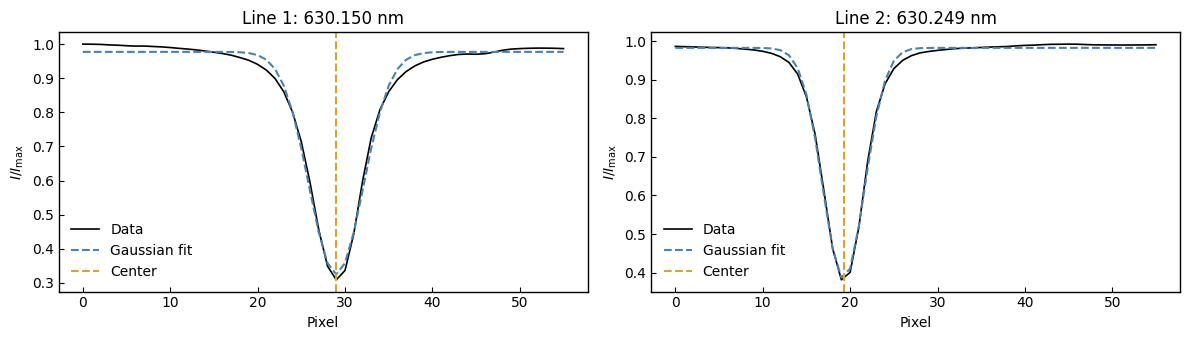

In [ ]:
def gaussian(x, amp, center, width, offset):
    """
    Returns a Gaussian profile for absorption line fitting.

    Parameters
    ----------
    x : array-like
        The independent variable (e.g., pixel or wavelength positions).
    amp : float
        Amplitude of the Gaussian (depth of the absorption).
    center : float
        Center position of the Gaussian (line center).
    width : float
        Standard deviation (width) of the Gaussian.
    offset : float
        Continuum level (baseline offset).

    Returns
    -------
    array-like
        The Gaussian profile evaluated at x.
    """
    return offset - amp * np.exp(-0.5 * ((x - center) / width)**2)

# Split spectrum and find centers via Gaussian fitting
mid_point = n_spec // 2
left_spec = intensity_avg[:mid_point]
right_spec = intensity_avg[mid_point:]

# Fit left line
x_left = np.arange(len(left_spec))
p0_left = [0.7, 29, 3.0, 1.0]  # Initial guess: amp, center, width, offset
popt_left, _ = curve_fit(gaussian, x_left, left_spec, p0=p0_left)
center_left = popt_left[1]

# Fit right line
x_right = np.arange(len(right_spec))
p0_right = [0.6, 19, 4.0, 1.0]  # Initial guess
popt_right, _ = curve_fit(gaussian, x_right, right_spec, p0=p0_right)
center_right = popt_right[1] + mid_point

line_centers = np.array([center_left, center_right])

print(f'Line centers (pixels): {line_centers}')

# Visualize calibration
fig, axes = plt.subplots(1, 2, figsize=(12, 3.5))

for ax, spec, x, popt, center_g, label in zip(
    axes,
    [left_spec, right_spec],
    [x_left, x_right],
    [popt_left, popt_right],
    [center_left, center_right],
    [f'Line 1: {REF_WAVELENGTHS[0]:.3f} nm',
     f'Line 2: {REF_WAVELENGTHS[1]:.3f} nm']
):
    ax.plot(x, spec, 'k-', lw=1.2, label='Data')
    ax.plot(x, gaussian(x, *popt), color='steelblue', ls='--', label='Gaussian fit')
    ax.axvline(popt[1], color='goldenrod', ls='--', lw=1.5, label='Center')

    ax.set_xlabel('Pixel')
    ax.set_ylabel(r'$I / I_{\mathrm{max}}$')
    ax.set_title(label)
    ax.legend(frameon=False)

plt.tight_layout()
plt.show()


### Build wavelength axis

Wavelength calibration
Slope: 0.002145 nm/pixel
Intercept: 630.087885 nm
Range: [630.088, 630.326] nm


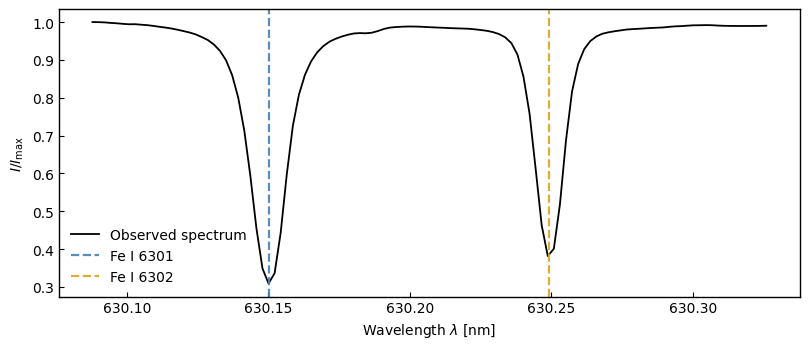

In [4]:
# Linear wavelength calibration: λ = a * pixel + b
delta_pixels = line_centers[1] - line_centers[0]
delta_lambda = REF_WAVELENGTHS[1] - REF_WAVELENGTHS[0]

slope = delta_lambda / delta_pixels
intercept = (line_centers[1] * REF_WAVELENGTHS[0] - 
             line_centers[0] * REF_WAVELENGTHS[1]) / delta_pixels

wavelength_axis = slope * pixel_indices + intercept

print('=========================')
print(f'Wavelength calibration')
print('=========================')
print(f'Slope: {slope:.6f} nm/pixel')
print(f'Intercept: {intercept:.6f} nm')
print(f'Range: [{wavelength_axis[0]:.3f}, {wavelength_axis[-1]:.3f}] nm')

# Plot calibrated spectrum
fig, ax = plt.subplots(figsize=(8.2, 3.6))

ax.plot(
    wavelength_axis,
    intensity_avg,
    color='k',
    lw=1.3,
    label='Observed spectrum'
)

ref_colors = ['steelblue', 'goldenrod']
ref_labels = ['Fe I 6301', 'Fe I 6302']

for wl, label, color in zip(REF_WAVELENGTHS, ref_labels, ref_colors):
    ax.axvline(
        wl,
        color=color,
        ls='--',
        lw=1.6,
        alpha=0.9,
        label=label
    )

ax.set_xlabel(r'Wavelength $\lambda$ [nm]')
ax.set_ylabel(r'$I / I_{\mathrm{max}}$')
ax.legend(frameon=False, loc='best')

plt.tight_layout()
plt.show()


# 4.2. Polarization Maps

We use median aggregation and robust peak finding methods.

In [5]:
# Load data
with fits.open(FILE_LOOP) as hdul:
    data_shape = hdul[0].data.shape
    print('===================================')
    print(f'Data shape: {data_shape}')
    print(f'(Stokes, Time, Y, X, Wavelength)')
    print('===================================')
    
    # Select times and wavelength range
    n_times = 20
    t_start = 1
    
    # Extract Stokes parameters for the second line
    mid_spec = data_shape[4] // 2
    
    I = hdul[0].data[0, t_start:t_start+n_times, :, :, mid_spec:]
    Q = hdul[0].data[1, t_start:t_start+n_times, :, :, mid_spec:]
    U = hdul[0].data[2, t_start:t_start+n_times, :, :, mid_spec:]
    V = hdul[0].data[3, t_start:t_start+n_times, :, :, mid_spec:]

print(f'Loaded {n_times} time steps for second line')
print(f'Spatial dimensions: {I.shape[1]} x {I.shape[2]}')
print(f'Spectral points: {I.shape[3]}')

Data shape: (4, 124, 18, 76, 112)
(Stokes, Time, Y, X, Wavelength)
Loaded 20 time steps for second line
Spatial dimensions: 18 x 76
Spectral points: 56


In [ ]:
def spectral_summary(cube, method='max_median'):
    '''
    Extract spectral feature from 3D cube (t, y, x, λ).
    
    Parameters:
    -----------
    cube : ndarray (t, y, x, λ)
        Data cube
    method : str
        'min': minimum over wavelength
        'max_median': median in window around maximum absolute value, 
                      preserving sign of extremum
    
    Returns:
    --------
    maps : ndarray (t, y, x)
        Summarized maps
    '''
    nt, ny, nx, nw = cube.shape
    maps = np.zeros((nt, ny, nx))
    
    if method == 'min':
        maps = np.min(cube, axis=3)
    
    elif method == 'max_median':
        # Find wavelength index of maximum absolute value per pixel
        peak_idx_abs = np.argmax(np.abs(cube), axis=3)
        
        # Find indices of maximum and minimum values
        max_idx = np.argmax(cube, axis=3)
        min_idx = np.argmin(cube, axis=3)
        
        # Extract median in +-2 pixel window around peak, preserving sign
        for t in range(nt):
            for y in range(ny):
                for x in range(nx):
                    idx = peak_idx_abs[t, y, x]
                    idx_max = max_idx[t, y, x]
                    idx_min = min_idx[t, y, x]
                    
                    idx_smaller = min(idx_max, idx_min)
                    
                    i_start = max(0, idx - 2)
                    i_end = min(nw, idx + 3)
                    window = cube[t, y, x, i_start:i_end]
                    
                    maps[t, y, x] = np.abs(np.mean(window)) * np.sign(cube[t, y, x, idx_smaller])
    
    return maps

# Create maps
I_map = spectral_summary(I, method='min')
Q_map = spectral_summary(Q, method='max_median')
U_map = spectral_summary(U, method='max_median')
V_map = spectral_summary(V, method='max_median')

# Total linear polarization
P_lin_map = np.sqrt(Q_map**2 + U_map**2)

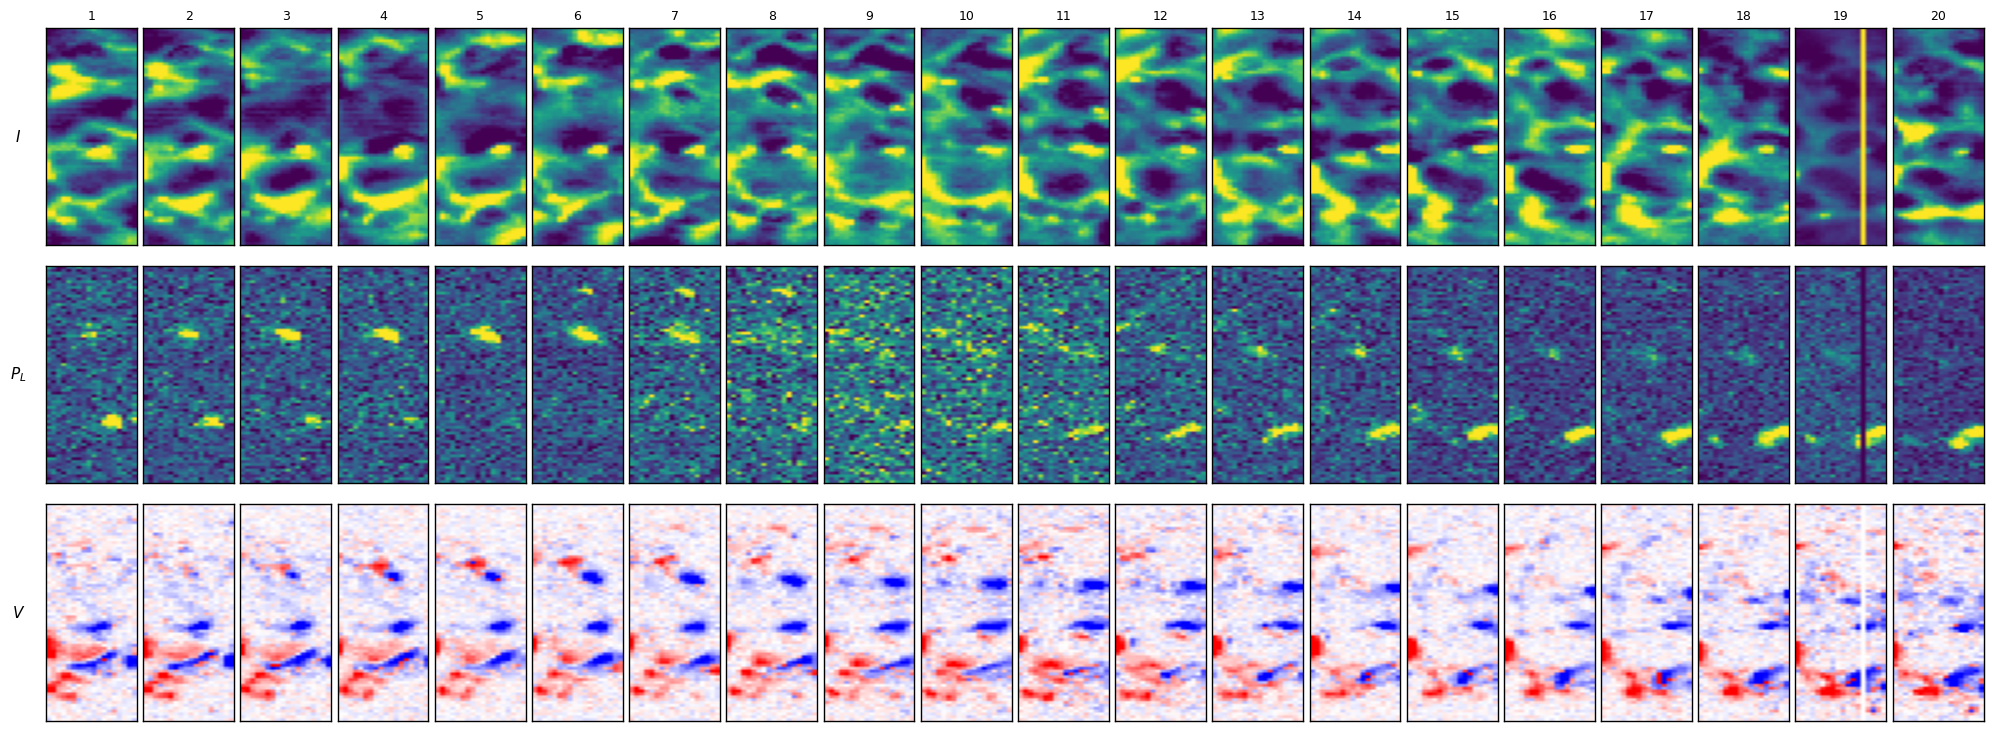

In [7]:
# Visualize polarization maps
fig = plt.figure(figsize=(25, 9))
gs = gridspec.GridSpec(3, 
                       n_times, 
                       wspace=0.07,
                       hspace=0.1
                       )

for row, (data_map, title) in enumerate([
    (I_map, r'$I$'),
    (P_lin_map, r'$P_L$'),
    (V_map, r'$V$')
]):
    for t in range(n_times):
        ax = fig.add_subplot(gs[row, t])
        
        # Apply different colormaps and contrast settings per Stokes parameter
        if row == 0:  # Intensity 
            vmin = np.percentile(data_map[t], 5)
            vmax = np.percentile(data_map[t], 95)
            im = ax.imshow(data_map[t].T, origin='lower', cmap='viridis',
                          vmin=vmin, vmax=vmax, aspect='auto')
        elif row == 1:  # Linear polarization
            vmin = np.percentile(data_map[t], 2)
            vmax = np.percentile(data_map[t], 99)
            im = ax.imshow(data_map[t].T, origin='lower', cmap='viridis',
                          vmin=vmin, vmax=vmax, aspect='auto')
        else:  # row == 2: Circular polarization
            vmin = -np.percentile(np.abs(data_map[t]), 98)
            vmax = np.percentile(np.abs(data_map[t]), 98)
            im = ax.imshow(data_map[t].T, origin='lower', cmap='bwr',
                          vmin=vmin, vmax=vmax, aspect='auto')
        
        ax.set_xticks([])
        ax.set_yticks([])
        
        if row == 0:
            ax.set_title(f'{t+t_start}', fontsize=9)
        if t == 0:
            ax.set_ylabel(title, rotation=0, labelpad=20, va='center', fontsize=11)

plt.show()

### Zoomed view of an emerging flux region

### Identification of magnetic flux emergence signatures

The polarization maps displayed above span 20 consecutive timesteps starting at $t=1$ and are inspected visually to identify signatures characteristic of emerging magnetic flux. No automated detection algorithm is implemented in this analysis, instead, identification relies on morphological pattern recognition of the Stokes parameter spatial distributions.

Flux emergence events manifest as bipolar magnetic structures in circular polarization maps. The characteristic signature consists of two regions with opposite polarities, appearing as $V>0$ and $V<0$ patches in Stokes V, that emerge simultaneously and progressively separate over time. Enhanced linear polarization $P_L$ is typically observed in the region connecting the two poles, indicating the presence of horizontal magnetic field components associated with the connecting flux tube. These structures persist across multiple consecutive timesteps, distinguishing them from transient noise fluctuations.

Visual inspection of the Stokes V maps reveals a clear bipolar structure visible between approximately $t=3$ and $t=15$ within the displayed sequence. The temporal evolution of this structure can be divided into several distinct phases. During the pre-emergence phase from $t=1$ to $t=2$, minimal or absent polarization signal is observed in the region where the flux will subsequently emerge. The emergence onset occurs between $t=3$ and $t=4$, marked by the sudden appearance of compact bipolar patches with opposite circular polarization. An expansion phase follows from $t=5$ to $t=10$, during which progressive separation of the poles is observed while the $P_L$ enhancement intensifies in the inter-polar region. Finally, a mature or decay phase extends from $t=11$ to $t=20$, characterized by continued evolution with gradual weakening of the polarization signals. This can be clearly seen in the next zoomed plot of this region:

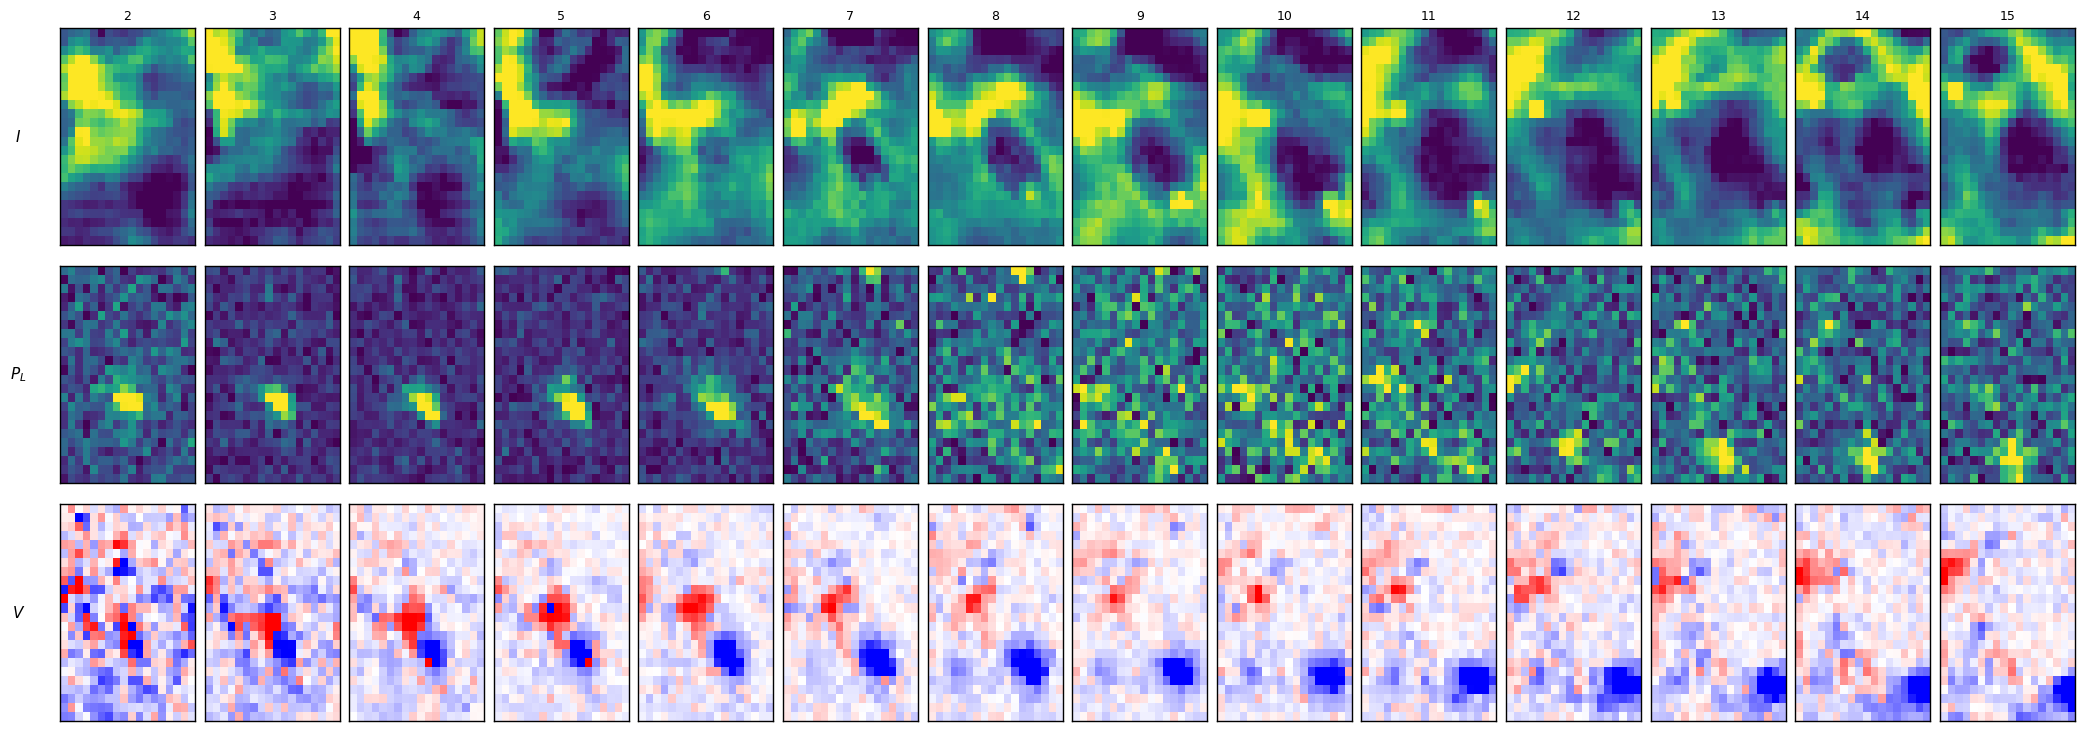

Zoomed region: X [0:18], Y [43:67]
Time range: t=2 to t=15
Zoomed spatial dimensions: 18 x 24 pixels


In [8]:
flux_center_x = 8  # Approximate center X coordinate
flux_center_y = 55  # Approximate center Y coordinate
flux_radius = 12    # Half-width of the zoom window

# Create spatial slices
x_zoom = slice(max(0, flux_center_x - flux_radius), 
               min(I_map.shape[1], flux_center_x + flux_radius))
y_zoom = slice(max(0, flux_center_y - flux_radius), 
               min(I_map.shape[2], flux_center_y + flux_radius))

# Time range focusing on emergence
t_zoom_start = 1
n_times_zoom = 14  # From t=2 to t=15

# Extract data
I_zoom = I_map[t_zoom_start:t_zoom_start+n_times_zoom, x_zoom, y_zoom]
P_zoom = P_lin_map[t_zoom_start:t_zoom_start+n_times_zoom, x_zoom, y_zoom]
V_zoom = V_map[t_zoom_start:t_zoom_start+n_times_zoom, x_zoom, y_zoom]

# Visualize polarization maps
fig_zoom = plt.figure(figsize=(26, 9))
gs_zoom = gridspec.GridSpec(3, n_times_zoom, wspace=0.07, hspace=0.1)

for row, (data_map_zoom, title) in enumerate([
    (I_zoom, r'$I$'),
    (P_zoom, r'$P_L$'),
    (V_zoom, r'$V$')
]):
    for t in range(n_times_zoom):
        ax = fig_zoom.add_subplot(gs_zoom[row, t])
        
        if row == 0:  # Intensity 
            vmin = np.percentile(data_map_zoom[t], 5)
            vmax = np.percentile(data_map_zoom[t], 95)
            im = ax.imshow(data_map_zoom[t].T, origin='lower', cmap='viridis',
                          vmin=vmin, vmax=vmax, aspect='auto')
        elif row == 1:  # Linear polarization
            vmin = np.percentile(data_map_zoom[t], 2)
            vmax = np.percentile(data_map_zoom[t], 99)
            im = ax.imshow(data_map_zoom[t].T, origin='lower', cmap='viridis',
                          vmin=vmin, vmax=vmax, aspect='auto')
        else:  # row == 2: Circular polarization
            vmin = -np.percentile(np.abs(data_map_zoom[t]), 98)
            vmax = np.percentile(np.abs(data_map_zoom[t]), 98)
            im = ax.imshow(data_map_zoom[t].T, origin='lower', cmap='bwr',
                          vmin=vmin, vmax=vmax, aspect='auto')
        
        ax.set_xticks([])
        ax.set_yticks([])
        
        if row == 0:
            ax.set_title(f'{t+t_zoom_start+t_start}', fontsize=9)
        if t == 0:
            ax.set_ylabel(title, rotation=0, labelpad=30, va='center', fontsize=11)

plt.show()

print(f'Zoomed region: X [{x_zoom.start}:{x_zoom.stop}], Y [{y_zoom.start}:{y_zoom.stop}]')
print(f'Time range: t={t_zoom_start+t_start} to t={t_zoom_start+t_start+n_times_zoom-1}')
print(f'Zoomed spatial dimensions: {I_zoom.shape[1]} x {I_zoom.shape[2]} pixels')


The spatial morphology of the identified bipolar structure shows several characteristic features. The bipolar axis is oriented obliquely, at approximately 30 to 60 degrees from the vertical Y-axis. One pole appears in the lower-right region of the field of view, while the opposite pole is located in the upper-left region. Linear polarization forms a concentrated enhancement between these poles, creating a bridge-like structure connecting the two footpoints.

This bipolar morphology is consistent with an emerging $\Omega$-loop magnetic flux tube rising from below the photosphere and breaking through the visible solar surface. The footpoints of the loop, anchored in regions of opposite magnetic polarity beneath the photosphere, appear as the bipolar patches observed in Stokes V. The enhanced linear polarization between the poles indicates the presence of inclined magnetic field lines connecting the footpoints, consistent with the three-dimensional geometry expected for a flux loop. The progressive separation of the poles over time reflects the expansion of the loop as it rises through the photosphere and extends into higher atmospheric layers.

# 4.3. Noise Characterization via Synthetic Testing

We validate the WFA method using Monte Carlo-style synthetic tests rather than traditional analytical error propagation. Monte Carlo simulation generates artificial noisy data by adding random Gaussian noise to clean synthetic profiles with known magnetic field parameters. By repeating this process 500 times and applying the WFA to each realization, we empirically measure how well the method recovers the true field parameters and quantify systematic biases introduced by noise.

In [9]:
# Load synthetic profile
with fits.open(FILE_SINT) as hdul:
    lambda_synth = hdul[0].data[0, :]
    I_synth = hdul[0].data[1, :]

print(f"Synthetic profile: {len(lambda_synth)} wavelength points")

# Compute derivatives
dI_dlambda = np.gradient(I_synth, lambda_synth)
d2I_dlambda2 = np.gradient(dI_dlambda, lambda_synth)

# WFA scaling factors for second line
lambda0 = REF_WAVELENGTHS[1] * 10  # Å
g_eff = G_EFF[1]
gbar = GBAR[1]

Ip_scaled = dI_dlambda * lambda0**2 * g_eff
Ipp_scaled = d2I_dlambda2 * 0.25 * lambda0**4 * gbar

Synthetic profile: 201 wavelength points


In [10]:
def monte_carlo_noise_analysis(Ip, Ipp, B_true, noise_level, n_realizations=500):
    '''Analyze WFA performance using Monte Carlo simulation.
    
    Parameters:
    -----------
    Ip, Ipp : array
        Scaled derivatives
    B_true : dict
        True field: {'B': strength, 'theta': inclination, 'chi': azimuth}
    noise_level : float
        RMS noise in Stokes
    n_realizations : int
        Number of Monte Carlo realizations
    
    Returns:
    --------
    results : dict
        Monte Carlo distributions and statistics
    '''
    # True field components
    B_par_true = B_true['B'] * np.cos(B_true['theta'])
    B_perp_sq = (B_true['B'] * np.sin(B_true['theta']))**2
    
    # Generate noise-free Stokes
    Q_clean = -C0**2 * B_perp_sq * np.cos(2 * B_true['chi']) * Ipp
    U_clean = -C0**2 * B_perp_sq * np.sin(2 * B_true['chi']) * Ipp
    V_clean = -C0 * B_par_true * Ip
    
    # Storage for magnetic field parameters
    B_par_mc = np.zeros(n_realizations)
    B_perp_mc = np.zeros(n_realizations)
    chi_mc = np.zeros(n_realizations)
    
    # Storage for Stokes profiles from all MC realizations
    n_wavelength = len(Ip)
    Q_all = np.zeros((n_realizations, n_wavelength))
    U_all = np.zeros((n_realizations, n_wavelength))
    V_all = np.zeros((n_realizations, n_wavelength))
    
    # Monte Carlo loop
    for i in range(n_realizations):
        # Add noise
        Q_noisy = Q_clean + np.random.normal(0, noise_level, Q_clean.shape)
        U_noisy = U_clean + np.random.normal(0, noise_level, U_clean.shape)
        V_noisy = V_clean + np.random.normal(0, noise_level, V_clean.shape)
        
        # Store noisy profiles
        Q_all[i] = Q_noisy
        U_all[i] = U_noisy
        V_all[i] = V_noisy
        
        # WFA inference
        sum_V_Ip = np.sum(V_noisy * Ip)
        sum_Ip_Ip = np.sum(Ip * Ip)
        sum_Q_Ipp = -np.sum(Q_noisy * Ipp)
        sum_U_Ipp = -np.sum(U_noisy * Ipp)
        sum_Ipp_Ipp = np.sum(Ipp * Ipp)
        
        B_par_mc[i] = (-1.0 / C0) * sum_V_Ip / sum_Ip_Ip
        B_perp_mc[i] = np.sqrt(np.sqrt(sum_Q_Ipp**2 + sum_U_Ipp**2) / sum_Ipp_Ipp) / C0
        chi_mc[i] = 0.5 * np.arctan2(sum_U_Ipp, sum_Q_Ipp)
    
    # Reconstruct with median estimates
    B_par_est = np.median(B_par_mc)
    B_perp_est = np.median(B_perp_mc)
    chi_est = np.median(chi_mc)
    
    B_perp_sq_est = B_perp_est**2
    Q_recon = -C0**2 * B_perp_sq_est * np.cos(2 * chi_est) * Ipp
    U_recon = -C0**2 * B_perp_sq_est * np.sin(2 * chi_est) * Ipp
    V_recon = -C0 * B_par_est * Ip
    
    return {
        'B_par': {'samples': B_par_mc, 
                  'median': B_par_est, 
                  'std': np.std(B_par_mc), 
                  'true': B_par_true},

        'B_perp': {'samples': B_perp_mc, 
                   'median': B_perp_est,
                   'std': np.std(B_perp_mc), 
                   'true': np.sqrt(B_perp_sq)},

        'chi': {'samples': chi_mc * 180/np.pi, 
                'median': chi_est * 180/np.pi,
                'std': np.std(chi_mc) * 180/np.pi, 
                'true': B_true['chi'] * 180/np.pi},
                
        'stokes': {
            'Q': {'clean': Q_clean, 'recon': Q_recon, 'all': Q_all},
            'U': {'clean': U_clean, 'recon': U_recon, 'all': U_all},
            'V': {'clean': V_clean, 'recon': V_recon, 'all': V_all}
        }
    }

# Test parameters
B_test = {
    'B': 800.0,  # Gauss
    'theta': np.pi * 0.45,
    'chi': np.pi * 0.5 * 0.33
}
noise_std = 1e-3

mc_results = monte_carlo_noise_analysis(
    Ip_scaled, Ipp_scaled, B_test, noise_std, n_realizations=500
)

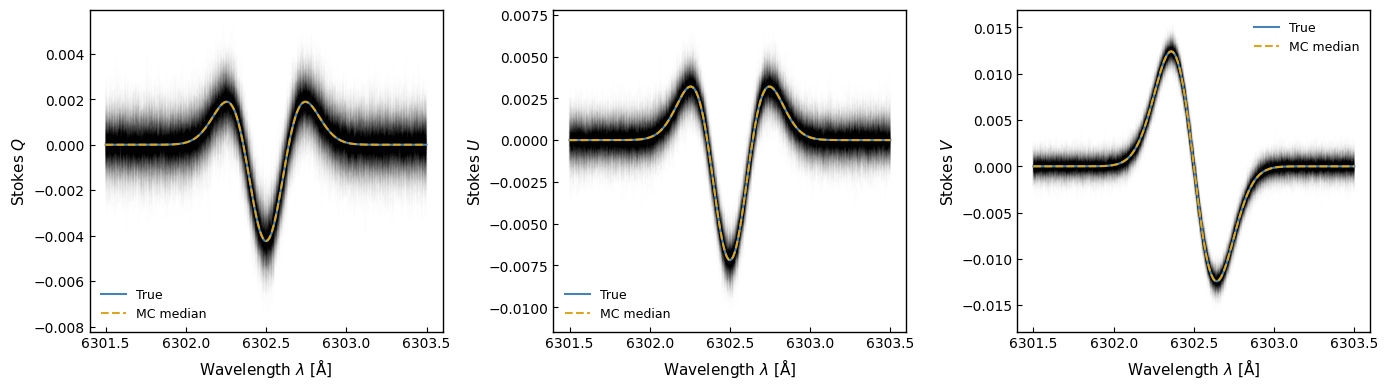

MONTE CARLO WFA INFERENCE SUMMARY
B_parallel  : True =  125.15 G
              Est  =  125.19 +-  1.72 G
              Bias =    0.04 G

B_perp      : True =  790.15 G
              Est  =  789.89 +- 10.87 G
              Bias =   -0.27 G

Azimuth     : True =   29.70 deg
              Est  =   29.75 +-  0.76 deg
              Bias =    0.05 deg



In [11]:
# Visualize Monte Carlo results
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for i, (ax, stokes) in enumerate(zip(axes, ['Q', 'U', 'V'])):
    clean = mc_results['stokes'][stokes]['clean']
    recon = mc_results['stokes'][stokes]['recon']
    all_realizations = mc_results['stokes'][stokes]['all']
    
    # MC realizations
    for mc_profile in all_realizations:
        ax.plot(lambda_synth, mc_profile, color='k', alpha=0.005)
    
    # True noise-free profile
    ax.plot(lambda_synth, clean, color='steelblue', label='True')
    
    # MC median reconstruction
    ax.plot(lambda_synth, recon, color='goldenrod', ls='--', label='MC median')
    
    ax.set_xlabel(r'Wavelength $\lambda$ [Å]', fontsize=11)
    ax.set_ylabel(f'Stokes ${stokes}$', fontsize=11)
    ax.legend(frameon=False, fontsize=9, loc='best')

plt.tight_layout()
plt.show()

# Print summary statistics
print('==================================')
print('MONTE CARLO WFA INFERENCE SUMMARY')
print('==================================')
for param, label, unit in [
    ('B_par', 'B_parallel', 'G'),
    ('B_perp', 'B_perp', 'G'),
    ('chi', 'Azimuth', 'deg')
]:
    data = mc_results[param]
    bias = data['median'] - data['true']
    print(f"{label:12s}: True = {data['true']:7.2f} {unit}")
    print(f"{'':12s}  Est  = {data['median']:7.2f} +- {data['std']:5.2f} {unit}")
    print(f"{'':12s}  Bias = {bias:7.2f} {unit}")
    print()


### Systematic Noise Study

To comprehensively characterize the accuracy and reliability of the WFA method across realistic observational conditions, we perform a systematic noise study following the methodology established by Martínez González et al. (2012). This analysis explores the WFA performance across a wide range of magnetic field configurations and polarimetric noise levels, enabling quantitative assessment of parameter recovery fidelity and identification of systematic biases.

The parameter space is sampled across four dimensions: magnetic field strength $B$ ranging from 30 to 1000 Gauss (10 logarithmically spaced values), field inclination $\theta$ from 1° to 179° (10 values avoiding singularities at 0° and 180°), field azimuth $\chi$ from 0° to 180° (10 values spanning the full physically meaningful range), and polarimetric noise levels spanning five orders of magnitude from $\sigma = 0, 5 \times 10^{-6}, 10^{-5}, 10^{-4}, 5 \times 10^{-4}, 10^{-3}, 5 \times 10^{-3}, 10^{-2}, 5 \times 10^{-2}$ in units of continuum intensity. This configuration yields 9000 unique parameter combinations.

For each parameter combination, we generate synthetic Stokes profiles corresponding to the specified magnetic field using the WFA forward model applied to the observed Fe I 6302.5 Å line profile. Gaussian noise with the specified standard deviation is added independently to the Q, U, and V profiles. This process is repeated 500 times via Monte Carlo realizations to build statistical distributions of the inferred field parameters. The WFA inversion is applied to each noisy realization, and the median and 68% confidence intervals are computed from the resulting distributions.

In [ ]:
def noise_study(Ip, Ipp, noise_levels, B_strengths, theta_values, chi_values, n_realizations=500):
    '''
    Systematic study of WFA performance across noise levels and field configurations.
    Reproduces the methodology from Martínez González et al. (2012).
    
    Parameters:
    -----------
    Ip, Ipp : array
        Scaled derivatives from synthetic profile
    noise_levels : array
        Array of noise levels to test (in units of I_c)
    B_strengths : array
        Array of magnetic field strengths to test (Gauss)
    theta_values : array
        Array of inclination angles to test (radians)
    chi_values : array
        Array of azimuth angles to test (radians)
    n_realizations : int
        Number of Monte Carlo realizations per configuration
    
    Returns:
    --------
    results : dict
        Nested dictionary
    '''
    results = {}
    n_wavelength = len(Ip)
    
    total_configs = len(noise_levels) * len(B_strengths) * len(theta_values) * len(chi_values)
    
    with tqdm(total=total_configs, desc='Noise study', unit='config') as pbar:
        for n_idx, noise in enumerate(noise_levels):
            results[n_idx] = {}
            
            for b_idx, B in enumerate(B_strengths):
                results[n_idx][b_idx] = {}
                
                for t_idx, theta in enumerate(theta_values):
                    results[n_idx][b_idx][t_idx] = {}
                    
                    for c_idx, chi in enumerate(chi_values):
                        pbar.set_postfix({
                            'noise': f'{noise:.0e}', 
                            'B': f'{B:.0f}G', 
                            'θ': f'{theta*180/np.pi:.0f}°',
                            'χ': f'{chi*180/np.pi:.0f}°'
                        })
                        
                        # True field components
                        B_par_true = B * np.cos(theta)
                        B_perp_true = B * np.sin(theta)
                        B_perp_sq = B_perp_true**2
                        
                        # Generate clean Stokes profiles
                        Q_clean = -C0**2 * B_perp_sq * np.cos(2*chi) * Ipp
                        U_clean = -C0**2 * B_perp_sq * np.sin(2*chi) * Ipp
                        V_clean = -C0 * B_par_true * Ip
                        
                        # Storage for MC samples
                        B_par_samples = np.zeros(n_realizations)
                        B_perp_samples = np.zeros(n_realizations)
                        theta_samples = np.zeros(n_realizations)
                        chi_samples = np.zeros(n_realizations)
                        
                        # Monte Carlo loop
                        for i in range(n_realizations):
                            # Add noise
                            Q_noisy = Q_clean + np.random.normal(0, noise, n_wavelength)
                            U_noisy = U_clean + np.random.normal(0, noise, n_wavelength)
                            V_noisy = V_clean + np.random.normal(0, noise, n_wavelength)
                            
                            # WFA inference
                            sum_V_Ip = np.sum(V_noisy * Ip)
                            sum_Ip_Ip = np.sum(Ip * Ip)
                            sum_Q_Ipp = -np.sum(Q_noisy * Ipp)
                            sum_U_Ipp = -np.sum(U_noisy * Ipp)
                            sum_Ipp_Ipp = np.sum(Ipp * Ipp)
                            
                            B_par_samples[i] = (-1.0/C0) * sum_V_Ip / sum_Ip_Ip
                            B_perp_samples[i] = np.sqrt(np.sqrt(sum_Q_Ipp**2 + sum_U_Ipp**2) / sum_Ipp_Ipp) / C0
                            chi_samples[i] = 0.5 * np.arctan2(sum_U_Ipp, sum_Q_Ipp)
                            
                            # Compute theta from inferred components
                            B_total = np.sqrt(B_par_samples[i]**2 + B_perp_samples[i]**2)
                            if B_total > 0:
                                theta_samples[i] = np.arccos(np.clip(B_par_samples[i]/B_total, -1, 1))
                            else:
                                theta_samples[i] = 0.0
                        
                        # Calculate statistics
                        results[n_idx][b_idx][t_idx][c_idx] = {
                            'B_par_true': B_par_true,
                            'B_par_median': np.median(B_par_samples),
                            'B_par_std': np.std(B_par_samples),
                            'B_par_p16': np.percentile(B_par_samples, 16),
                            'B_par_p84': np.percentile(B_par_samples, 84),
                            'B_perp_true': B_perp_true,
                            'B_perp_median': np.median(B_perp_samples),
                            'B_perp_std': np.std(B_perp_samples),
                            'B_perp_p16': np.percentile(B_perp_samples, 16),
                            'B_perp_p84': np.percentile(B_perp_samples, 84),
                            'theta_true': theta * 180/np.pi,
                            'theta_median': np.median(theta_samples) * 180/np.pi,
                            'theta_std': np.std(theta_samples) * 180/np.pi,
                            'theta_p16': np.percentile(theta_samples, 16) * 180/np.pi,
                            'theta_p84': np.percentile(theta_samples, 84) * 180/np.pi,
                            'chi_true': chi * 180/np.pi,
                            'chi_median': np.median(chi_samples) * 180/np.pi,
                            'chi_std': np.std(chi_samples) * 180/np.pi,
                            'chi_p16': np.percentile(chi_samples, 16) * 180/np.pi,
                            'chi_p84': np.percentile(chi_samples, 84) * 180/np.pi,
                        }
                        
                        pbar.update(1)
    
    return results

In [26]:
# Noise levels
noise_levels = np.array([0, 5e-6, 1e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2])

# Magnetic field strengths (Gauss)
B_strengths = np.linspace(30, 1000, 10)

# Inclination angles (radians)
theta_values = np.linspace(np.pi/180, 179*np.pi/180, 10)

# Azimuth angles (radians)
chi_values = np.linspace(0, np.pi, 10)

In [14]:
noise_study_results = noise_study(
    Ip_scaled, Ipp_scaled, 
    noise_levels, B_strengths, theta_values, chi_values,
    n_realizations=500
)

Noise study: 100%|██████████| 9000/9000 [02:08<00:00, 70.21config/s, noise=5e-02, B=1000G, θ=179°, χ=180°]


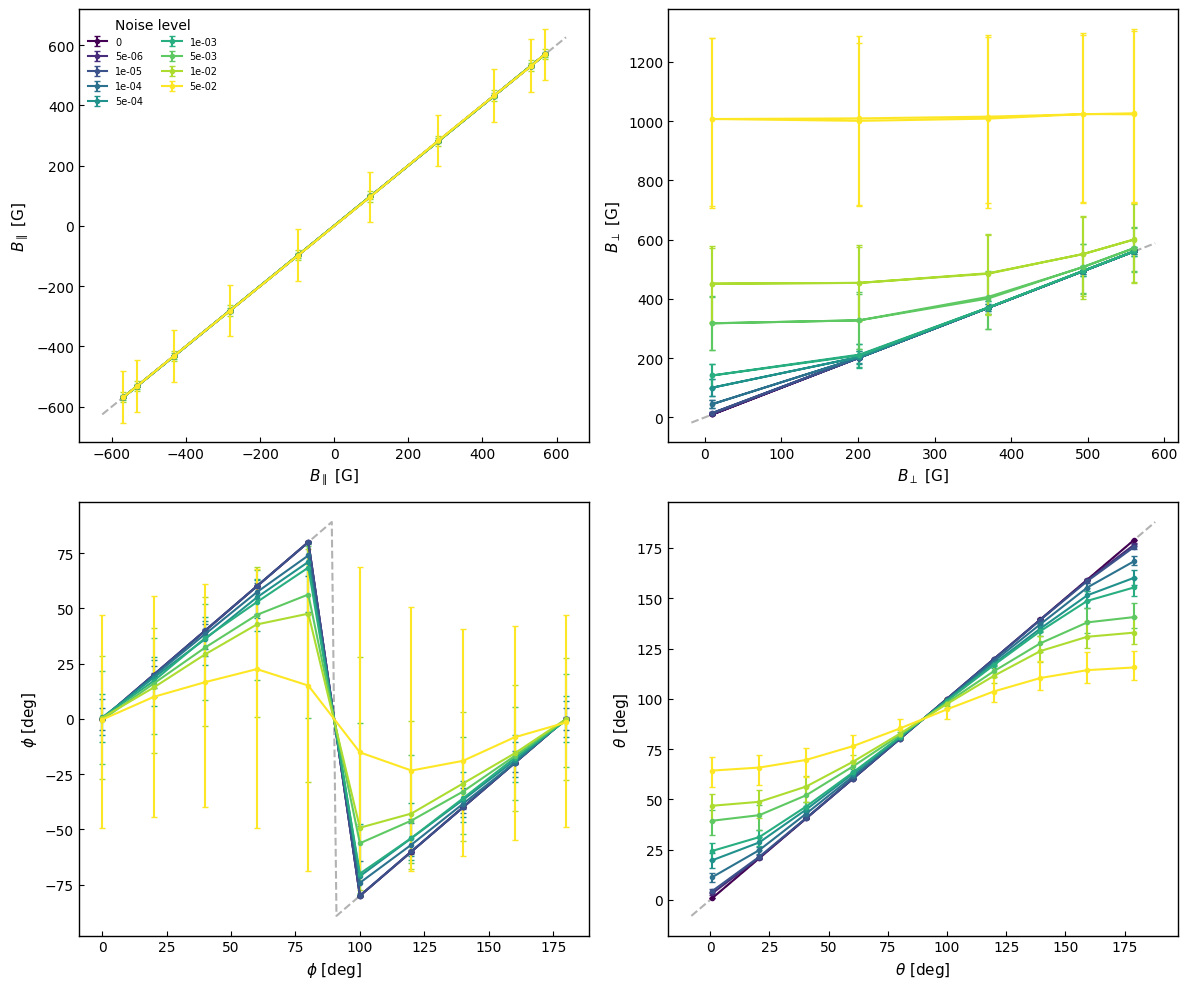

In [ ]:
def plot_noise_study_figure2(results, noise_levels, B_strengths, theta_values, chi_values):
    """
    Reproduce Figure 2 from Martínez González et al. (2012): 
    Visualizes the effect of noise on the inference of magnetic field parameters using Monte Carlo simulations.

    Parameters
    ----------
    results : nested list/dict
        Monte Carlo results for each combination of noise, field strength, inclination, and azimuth.
        Each entry should contain the medians and confidence intervals for B_parallel, B_perp, chi, and theta.
    noise_levels : array-like
        List of noise standard deviations used in the simulations.
    B_strengths : array-like
        List of magnetic field strengths [G] used in the simulations.
    theta_values : array-like
        List of inclination angles [radians] used in the simulations.
    chi_values : array-like
        List of azimuth angles [radians] used in the simulations.

    Returns
    -------
    None
        Displays a 2x2 matplotlib figure with error bars comparing true and inferred values for:
        - B_parallel
        - B_perp
        - Azimuth (phi)
        - Inclination (theta)
    """
    
    cmap = plt.get_cmap('viridis')
    colors = [cmap(i / (len(noise_levels)-1)) for i in range(len(noise_levels))]
    
    # Create figure with 2x2 layout
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Top-left: B_parallel vs B_parallel
    ax = axes[0, 0]
    B_fixed_idx = len(B_strengths) // 2
    B_fixed = B_strengths[B_fixed_idx]
    
    for n_idx, noise in enumerate(noise_levels):
        true_B_par = []
        inferred_B_par = []
        errors_lower = []
        errors_upper = []
        
        for t_idx in range(len(theta_values)):
            medians = []
            p16s = []
            p84s = []
            
            for c_idx in range(len(chi_values)):
                r = results[n_idx][B_fixed_idx][t_idx][c_idx]
                medians.append(r['B_par_median'])
                p16s.append(r['B_par_p16'])
                p84s.append(r['B_par_p84'])
            
            true_B_par.append(B_fixed * np.cos(theta_values[t_idx]))
            inferred_B_par.append(np.mean(medians))
            errors_lower.append(np.mean(medians) - np.mean(p16s))
            errors_upper.append(np.mean(p84s) - np.mean(medians))
        
        ax.errorbar(true_B_par, inferred_B_par, 
                   yerr=[errors_lower, errors_upper],
                   fmt='o-', 
                   color=colors[n_idx],
                   markersize=3,
                   capsize=2,
                   label=f'{noise:.0e}' if noise > 0 else '0'
                   )
        
    
    lim = ax.get_xlim()
    ax.plot(lim, lim, 'k--', alpha=0.3)
    ax.set_xlabel(r'$B_\parallel$ [G]', fontsize=11)
    ax.set_ylabel(r'$B_\parallel$ [G]', fontsize=11)
    ax.legend(fontsize=7, title='Noise level', ncol=2, frameon=False, loc='upper left')
    
    # Top-right: B_perp vs B_perp
    ax = axes[0, 1]
    for n_idx, noise in enumerate(noise_levels):
        true_B_perp = []
        inferred_B_perp = []
        errors_lower = []
        errors_upper = []
        
        for t_idx in range(len(theta_values)):
            medians = []
            p16s = []
            p84s = []
            
            for c_idx in range(len(chi_values)):
                r = results[n_idx][B_fixed_idx][t_idx][c_idx]
                medians.append(r['B_perp_median'])
                p16s.append(r['B_perp_p16'])
                p84s.append(r['B_perp_p84'])
            
            true_B_perp.append(B_fixed * np.sin(theta_values[t_idx]))
            inferred_B_perp.append(np.mean(medians))
            errors_lower.append(np.mean(medians) - np.mean(p16s))
            errors_upper.append(np.mean(p84s) - np.mean(medians))
        
        ax.errorbar(true_B_perp, inferred_B_perp,
                   yerr=[errors_lower, errors_upper],
                   fmt='o-', 
                   color=colors[n_idx],
                   markersize=3,
                   capsize=2
                   )
    
    lim = ax.get_xlim()
    ax.plot(lim, lim, 'k--', alpha=0.3)
    ax.set_xlabel(r'$B_\perp$ [G]', fontsize=11)
    ax.set_ylabel(r'$B_\perp$ [G]', fontsize=11)
    
    # Bottom-left: phi (azimuth) vs phi (azimuth)
    ax = axes[1, 0]
    B_mid_idx = len(B_strengths) // 2
    theta_mid_idx = len(theta_values) // 2 
    
    for n_idx, noise in enumerate(noise_levels):
        true_phi_deg = []
        inferred_phi_deg = []
        errors_lower = []
        errors_upper = []
        
        for c_idx in range(len(chi_values)):
            medians = []
            p16s = []
            p84s = []
            
            for b_idx in range(len(B_strengths)):
                r = results[n_idx][b_idx][theta_mid_idx][c_idx]
                
                medians.append(r['chi_median'])
                p16s.append(r['chi_p16'])
                p84s.append(r['chi_p84'])
            
            true_phi_deg.append(chi_values[c_idx] * 180/np.pi)
            inferred_phi_deg.append(np.mean(medians))
            
            mean_med = np.mean(medians)
            mean_p16 = np.mean(p16s)
            mean_p84 = np.mean(p84s)
            errors_lower.append(abs(mean_med - mean_p16))
            errors_upper.append(abs(mean_p84 - mean_med))
        
        ax.errorbar(true_phi_deg, inferred_phi_deg,
                   yerr=[errors_lower, errors_upper],
                   fmt='o-', 
                   color=colors[n_idx],
                   markersize=3,
                   capsize=2
                   )
    
    phi_ref = np.linspace(0, 180, 100)
    phi_expected = np.where(phi_ref <= 90, phi_ref, phi_ref - 180)
    ax.plot(phi_ref, phi_expected, 'k--', alpha=0.3)
    
    ax.set_xlabel(r'$\phi$ [deg]', fontsize=11)
    ax.set_ylabel(r'$\phi$ [deg]', fontsize=11)
    
    # Bottom-right: theta (inclination) vs theta (inclination)
    ax = axes[1, 1]
    B_mid_idx = len(B_strengths) // 2
    chi_mid_idx = len(chi_values) // 2
    
    for n_idx, noise in enumerate(noise_levels):
        true_theta_deg = []
        inferred_theta_deg = []
        errors_lower = []
        errors_upper = []
        
        for t_idx in range(len(theta_values)):
            medians = []
            p16s = []
            p84s = []
            
            for b_idx in range(len(B_strengths)):
                r = results[n_idx][b_idx][t_idx][chi_mid_idx]
                
                medians.append(r['theta_median'])
                p16s.append(r['theta_p16'])
                p84s.append(r['theta_p84'])
            
            true_theta_deg.append(np.rad2deg(theta_values[t_idx]))
            inferred_theta_deg.append(np.mean(medians))
            
            mean_med = np.mean(medians)
            mean_p16 = np.mean(p16s)
            mean_p84 = np.mean(p84s)
            errors_lower.append(abs(mean_med - mean_p16))
            errors_upper.append(abs(mean_p84 - mean_med))
        
        ax.errorbar(true_theta_deg, inferred_theta_deg,
                   yerr=[errors_lower, errors_upper],
                   fmt='o-', 
                   color=colors[n_idx], 
                   markersize=3,
                   capsize=2
                   )
        
    lim = ax.get_xlim()
    ax.plot(lim, lim, 'k--', alpha=0.3)
    ax.set_xlabel(r'$\theta$ [deg]', fontsize=11)
    ax.set_ylabel(r'$\theta$ [deg]', fontsize=11)

    plt.tight_layout()
    plt.show()

plot_noise_study_figure2(noise_study_results, noise_levels, B_strengths, theta_values, chi_values)

The four-panel diagnostic figure displays WFA performance across the tested noise levels and field configurations. The top-left panel shows inferred versus true line-of-sight field $B_\parallel$ by varying inclination $\theta$ at fixed field strength $B = 515$ G and averaging over azimuth. The top-right panel presents the analogous analysis for transverse field $B_\perp$. The bottom-left panel displays azimuth $\phi$ recovery by varying $\chi$ at fixed $\theta \approx 90°$ and averaging over field strengths. The bottom-right panel shows inclination $\theta$ recovery by varying $\theta$ at mid-range azimuth and averaging over field strengths. Error bars represent 68% confidence intervals from the Monte Carlo distributions.

The line-of-sight component $B_\parallel$ shows excellent agreement with true values at noise levels $\sigma < 10^{-3}$ with minimal systematic bias. This robustness reflects the linear relationship between Stokes V and $B_\parallel$, which provides stable inference even at moderate noise. The transverse component $B_\perp$ exhibits greater noise sensitivity due to the fourth-root relationship $B_\perp \propto (Q^2 + U^2)^{1/4}$. At noise levels $\sigma > 5 \times 10^{-3}$, a systematic positive bias emerges from the non-negativity constraint. For our observational noise level, $B_\perp$ measurements remain reliable but show larger uncertainties than $B_\parallel$.

Azimuth recovery performs well at low noise but degrades rapidly as noise increases, since azimuth determination depends on the ratio U/Q which becomes ill-defined near the noise level. Inclination recovery is reliable for intermediate angles ($30° < \theta < 150°$) but shows large uncertainties near $\theta \approx 0°$ or $180°$ where the transverse field component becomes negligible.

The results demonstrate a clear noise tolerance hierarchy. The WFA performs optimally for $\sigma < 10^{-4}$ with negligible bias, remains reliable for $10^{-4} < \sigma < 10^{-3}$, and shows manageable degradation at $\sigma \approx 10^{-3}$ comparable to our observational data. Beyond $\sigma > 5 \times 10^{-3}$, systematic biases in $B_\perp$ and poorly constrained azimuth values indicate that WFA-based inference becomes questionable.

# 4.4. Noise Estimation and WFA Application to Observations

sigma_Q = 0.001859
sigma_U = 0.001859
sigma_V = 0.001717
sigma_P = 0.001270


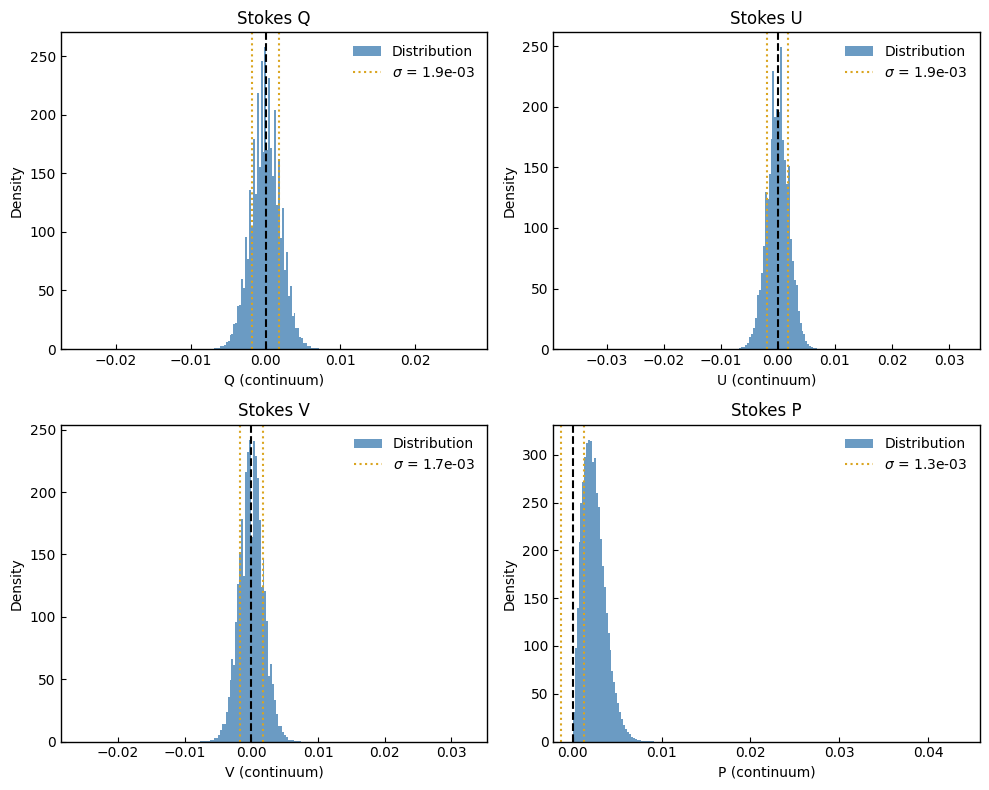

In [16]:
# Load full cube for noise estimation
with fits.open(FILE_LOOP) as hdul:
    cont_windows = [slice(0, 7), slice(45, 62), slice(93, None)]
    
    Q_cont = np.concatenate([hdul[0].data[1, :, :, :, w] for w in cont_windows], axis=3)
    U_cont = np.concatenate([hdul[0].data[2, :, :, :, w] for w in cont_windows], axis=3)
    V_cont = np.concatenate([hdul[0].data[3, :, :, :, w] for w in cont_windows], axis=3)

# Median absolute deviation
sigma_Q = median_abs_deviation(Q_cont.ravel(), scale='normal')
sigma_U = median_abs_deviation(U_cont.ravel(), scale='normal')
sigma_V = median_abs_deviation(V_cont.ravel(), scale='normal')

P_cont = np.sqrt(Q_cont**2 + U_cont**2)
sigma_P = median_abs_deviation(P_cont.ravel(), scale='normal')

print(f'sigma_Q = {sigma_Q:.6f}')
print(f'sigma_U = {sigma_U:.6f}')
print(f'sigma_V = {sigma_V:.6f}')
print(f'sigma_P = {sigma_P:.6f}')

# Visualize noise distributions
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
for ax, (data, sigma, label) in zip(axes.ravel(), [
    (Q_cont.ravel(), sigma_Q, 'Q'),
    (U_cont.ravel(), sigma_U, 'U'),
    (V_cont.ravel(), sigma_V, 'V'),
    (P_cont.ravel(), sigma_P, 'P')
]):
    ax.hist(data, bins=200, density=True, alpha=0.8, color='steelblue', label='Distribution')
    ax.axvline(0, color='k', ls='--')
    ax.axvline(sigma, color='goldenrod', ls='dotted', label=rf'$\sigma$ = {sigma:.1e}')
    ax.axvline(-sigma, color='goldenrod', ls='dotted')
    ax.set_xlabel(f'{label} (continuum)')
    ax.set_ylabel('Density')
    ax.legend(frameon=False)
    ax.set_title(f'Stokes {label}')
    
plt.tight_layout()
plt.show()

### WFA Application to Observations

In [17]:
# Load observations for WFA
with fits.open(FILE_LOOP) as hdul:
    n_times_wfa = 10
    t_start_wfa = 2
    
    shape = hdul[0].data.shape
    mid_spec = shape[4] // 2
    
    # Extract second line
    I_obs = hdul[0].data[0, t_start_wfa:t_start_wfa+n_times_wfa, :, :, mid_spec:]
    Q_obs = hdul[0].data[1, t_start_wfa:t_start_wfa+n_times_wfa, :, :, mid_spec:]
    U_obs = hdul[0].data[2, t_start_wfa:t_start_wfa+n_times_wfa, :, :, mid_spec:]
    V_obs = hdul[0].data[3, t_start_wfa:t_start_wfa+n_times_wfa, :, :, mid_spec:]

# Wavelength axis for second line (Å)
lambda_wfa = wavelength_axis[mid_spec:] * 10  # nm -> Å

# Compute scaled derivatives
dI = np.gradient(I_obs, lambda_wfa, axis=3)
d2I = np.gradient(dI, lambda_wfa, axis=3)

lambda0 = REF_WAVELENGTHS[1] * 10
g_eff = G_EFF[1]
gbar = GBAR[1]

Ip = dI * lambda0**2 * g_eff
Ipp = d2I * 0.25 * lambda0**4 * gbar

In [27]:
# WFA inference with uncertainty propagation
nt, ny, nx, nw = I_obs.shape

# Initialize output arrays
B_los = np.zeros((nt, ny, nx))
B_trans = np.zeros((nt, ny, nx))
chi_B = np.zeros((nt, ny, nx))
sigma_B_los = np.zeros((nt, ny, nx))
sigma_B_trans = np.zeros((nt, ny, nx))
sigma_chi_B = np.zeros((nt, ny, nx))
bias_B_trans = np.zeros((nt, ny, nx))

# Sum over wavelength
sum_V_Ip = np.sum(V_obs * Ip, axis=3)
sum_Ip_Ip = np.sum(Ip * Ip, axis=3)
sum_Q_Ipp = -np.sum(Q_obs * Ipp, axis=3)
sum_U_Ipp = -np.sum(U_obs * Ipp, axis=3)
sum_Ipp_Ipp = np.sum(Ipp * Ipp, axis=3)

# WFA inference
B_los = (-1.0 / C0) * sum_V_Ip / sum_Ip_Ip
sigma_B_los = sigma_V / np.sqrt(sum_Ip_Ip) / C0

B_trans = np.sqrt(np.sqrt(sum_Q_Ipp**2 + sum_U_Ipp**2) / sum_Ipp_Ipp) / C0
chi_B = 0.5 * np.arctan2(sum_U_Ipp, sum_Q_Ipp)

# Handle zero B_perp
mask_valid = B_trans > 0

sigma_B_trans = np.where(mask_valid,
                         0.5 * sigma_P / np.sqrt(sum_Ipp_Ipp) / B_trans / C0**2,
                         np.nan)

sigma_chi_B = np.where(mask_valid,
                       0.5 * sigma_P / np.sqrt(sum_Ipp_Ipp) / B_trans**2 / C0**2,
                       np.nan)

bias_B_trans = np.sqrt(sigma_P) * (2.0 / sum_Ipp_Ipp)**0.25 / C0

# Convert azimuth to degrees in [-90, 90]
chi_B_deg = np.rad2deg(chi_B)
chi_B_deg = np.mod(chi_B_deg + 90, 180) - 90
sigma_chi_B_deg = np.rad2deg(sigma_chi_B)

/tmp/ipykernel_38473/1401741407.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


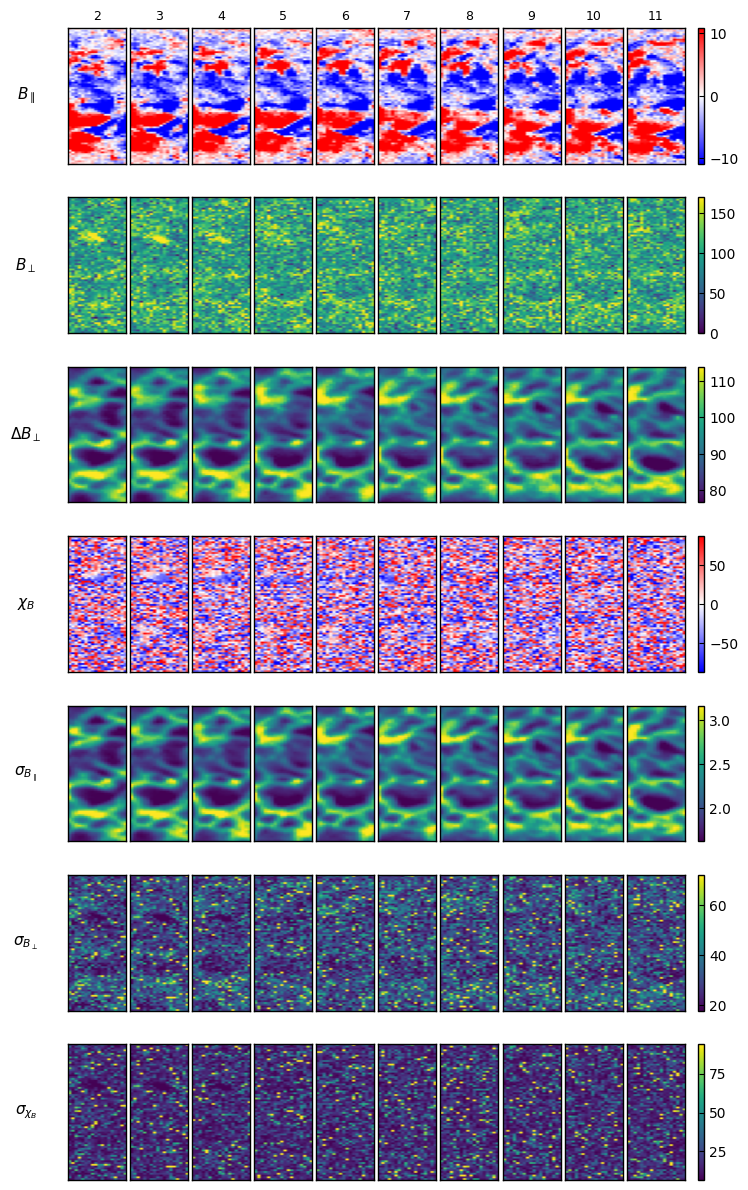

In [19]:
# Visualize WFA results
nrow = 7
ncol = n_times_wfa

fig = plt.figure(figsize=(14, 12))
gs = gridspec.GridSpec(nrow, ncol, wspace=0.07, hspace=0.25,
                       left=0.08, right=0.98, top=0.98, bottom=0.02)

row_data = [
    (B_los, r'$B_{\parallel}$'),
    (B_trans, r'$B_{\perp}$'),
    (bias_B_trans, r'$\Delta B_{\perp}$'),
    (chi_B_deg, r'$\chi_B$'),
    (sigma_B_los, r'$\sigma_{B_{\parallel}}$'),
    (sigma_B_trans, r'$\sigma_{B_{\perp}}$'),
    (sigma_chi_B_deg, r'$\sigma_{\chi_B}$')
]

for r, (data, label) in enumerate(row_data):
    # Compute global vmin/vmax for the entire row
    vmin = np.nanpercentile(data, 2)
    vmax = np.nanpercentile(data, 98)
    
    if r in [0, 3]:  # B_parallel and chi_B
        vmax = max(abs(vmin), abs(vmax))
        vmin = -vmax
        if r == 0:
            vmin *= 0.3
            vmax *= 0.3
        cmap = 'bwr'
    else:
        if r == 1:  # B_perp
            vmin = 0
        cmap = 'viridis'
    
    axes_row = []
    for t in range(ncol):
        ax = fig.add_subplot(gs[r, t])
        axes_row.append(ax)
        
        im = ax.imshow(data[t].T, origin='lower', cmap=cmap, 
                      vmin=vmin, vmax=vmax, aspect='auto')
        
        ax.set_xticks([])
        ax.set_yticks([])
        
        if r == 0:
            ax.set_title(f'{t+t_start_wfa}', fontsize=9)
        if t == 0:
            ax.set_ylabel(label, rotation=0, labelpad=30, va='center', fontsize=11)
    
    # Colorbars
    cbar = fig.colorbar(im, ax=axes_row, orientation='vertical', 
                       fraction=0.5, pad=0.01)

plt.tight_layout()
plt.show()

### Monte Carlo Error Estimation

As an alternative to the analytical error propagation, we can estimate uncertainties empirically using Monte Carlo simulation. This approach adds Gaussian noise to the observed Stokes profiles and re-applies the WFA multiple times to build statistical distributions of the inferred magnetic field parameters.

In [20]:
def monte_carlo_wfa_errors(Q_obs, U_obs, V_obs, Ip, Ipp, 
                           sigma_Q, sigma_U, sigma_V, n_realizations=500):
    '''
    Estimate WFA uncertainties using Monte Carlo simulation on observed data.
    
    Parameters:
    -----------
    Q_obs, U_obs, V_obs : ndarray (nt, ny, nx, nw)
        Observed Stokes parameters
    Ip, Ipp : ndarray (nt, ny, nx, nw)
        Scaled derivatives
    sigma_Q, sigma_U, sigma_V : float
        Noise levels from continuum
    n_realizations : int
        Number of Monte Carlo realizations
    
    Returns:
    --------
    results : dict
        Dictionary containing median and std for B_los, B_trans, chi_B
    '''
    nt, ny, nx, nw = Q_obs.shape
    
    # Storage for MC samples
    B_los_mc = np.zeros((n_realizations, nt, ny, nx))
    B_trans_mc = np.zeros((n_realizations, nt, ny, nx))
    chi_B_mc = np.zeros((n_realizations, nt, ny, nx))
    
    for i in tqdm(range(n_realizations), desc='Running Monte Carlo'):
        # Add noise to Stokes profiles
        Q_noisy = Q_obs + np.random.normal(0, sigma_Q, Q_obs.shape)
        U_noisy = U_obs + np.random.normal(0, sigma_U, U_obs.shape)
        V_noisy = V_obs + np.random.normal(0, sigma_V, V_obs.shape)
        
        # Apply WFA to noisy data
        sum_V_Ip = np.sum(V_noisy * Ip, axis=3)
        sum_Ip_Ip = np.sum(Ip * Ip, axis=3)
        sum_Q_Ipp = -np.sum(Q_noisy * Ipp, axis=3)
        sum_U_Ipp = -np.sum(U_noisy * Ipp, axis=3)
        sum_Ipp_Ipp = np.sum(Ipp * Ipp, axis=3)
        
        B_los_mc[i] = (-1.0 / C0) * sum_V_Ip / sum_Ip_Ip
        B_trans_mc[i] = np.sqrt(np.sqrt(sum_Q_Ipp**2 + sum_U_Ipp**2) / sum_Ipp_Ipp) / C0
        chi_B_mc[i] = 0.5 * np.arctan2(sum_U_Ipp, sum_Q_Ipp)
    
    # Compute statistics
    results = {
        'B_los_median': np.median(B_los_mc, axis=0),
        'B_los_std': np.std(B_los_mc, axis=0),
        'B_los_p16': np.percentile(B_los_mc, 16, axis=0),
        'B_los_p84': np.percentile(B_los_mc, 84, axis=0),
        
        'B_trans_median': np.median(B_trans_mc, axis=0),
        'B_trans_std': np.std(B_trans_mc, axis=0),
        'B_trans_p16': np.percentile(B_trans_mc, 16, axis=0),
        'B_trans_p84': np.percentile(B_trans_mc, 84, axis=0),
        
        'chi_B_median': np.median(chi_B_mc, axis=0),
        'chi_B_std': np.std(chi_B_mc, axis=0),
        'chi_B_p16': np.percentile(chi_B_mc, 16, axis=0),
        'chi_B_p84': np.percentile(chi_B_mc, 84, axis=0),
    }
    
    return results

In [21]:
mc_wfa_results = monte_carlo_wfa_errors(
    Q_obs, U_obs, V_obs, Ip, Ipp,
    sigma_Q, sigma_U, sigma_V,
    n_realizations=500
)

Running Monte Carlo: 100%|██████████| 500/500 [00:16<00:00, 29.84it/s]


/tmp/ipykernel_38473/3069438322.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


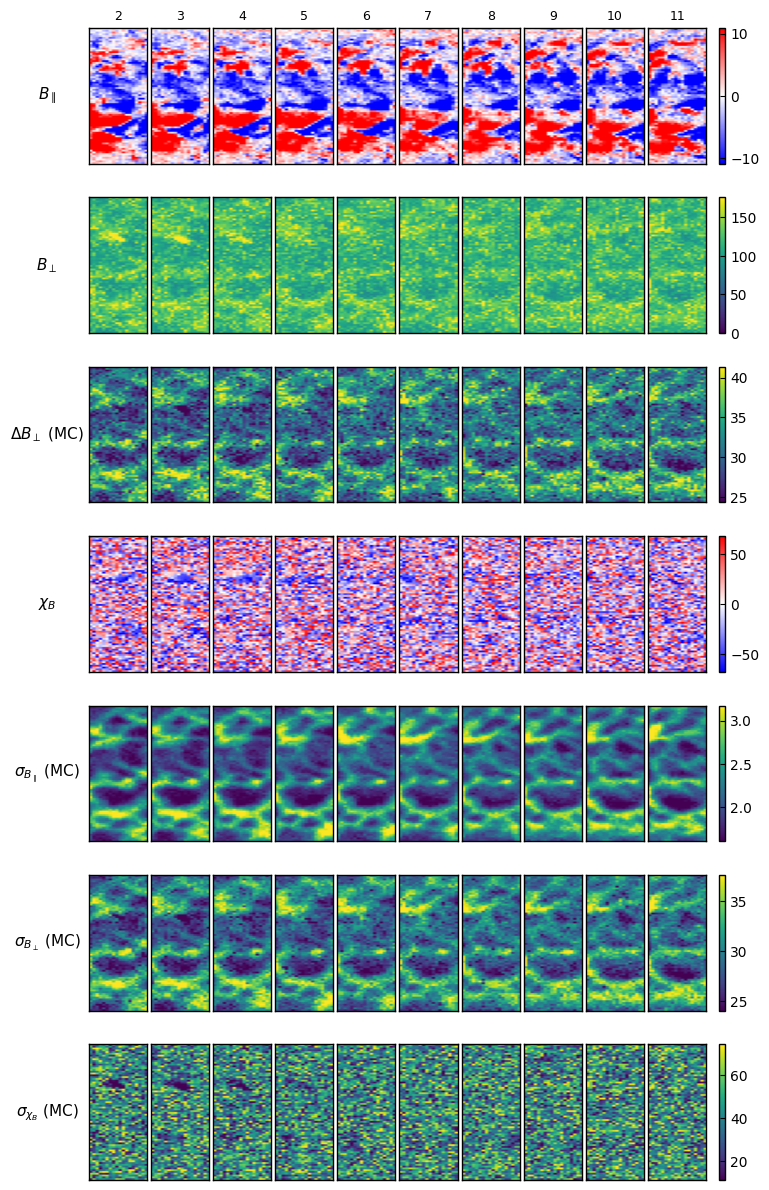

In [24]:
row_data_mc = [
    (mc_wfa_results['B_los_median'], r'$B_{\parallel}$'),
    (mc_wfa_results['B_trans_median'], r'$B_{\perp}$'),
    (mc_wfa_results['B_trans_median'] - mc_wfa_results['B_trans_p16'], r'$\Delta B_{\perp}$ (MC)'),
    (np.rad2deg(mc_wfa_results['chi_B_median']), r'$\chi_B$'),
    (mc_wfa_results['B_los_std'], r'$\sigma_{B_{\parallel}}$ (MC)'),
    (mc_wfa_results['B_trans_std'], r'$\sigma_{B_{\perp}}$ (MC)'),
    (np.rad2deg(mc_wfa_results['chi_B_std']), r'$\sigma_{\chi_B}$ (MC)')
]

# Visualize WFA results with Monte Carlo uncertainties
nrow = 7
ncol = n_times_wfa

fig = plt.figure(figsize=(14, 12))
gs = gridspec.GridSpec(nrow, ncol, wspace=0.07, hspace=0.25,
                       left=0.08, right=0.98, top=0.98, bottom=0.02)

for r, (data, label) in enumerate(row_data_mc):
    # Compute global vmin/vmax for the entire row
    vmin = np.nanpercentile(data, 2)
    vmax = np.nanpercentile(data, 98)
    
    if r in [0, 3]:  # B_parallel and chi_B
        vmax = max(abs(vmin), abs(vmax))
        vmin = -vmax
        if r == 0:
            vmin *= 0.3
            vmax *= 0.3
        cmap = 'bwr'
    else:
        if r == 1:  # B_perp
            vmin = 0
        cmap = 'viridis'
    
    axes_row = []
    for t in range(ncol):
        ax = fig.add_subplot(gs[r, t])
        axes_row.append(ax)
        
        im = ax.imshow(data[t].T, origin='lower', cmap=cmap, 
                      vmin=vmin, vmax=vmax, aspect='auto')
        
        ax.set_xticks([])
        ax.set_yticks([])
        
        if r == 0:
            ax.set_title(f'{t+t_start_wfa}', fontsize=9)
        if t == 0:
            ax.set_ylabel(label, rotation=0, labelpad=30, va='center', fontsize=11)
    
    # Colorbars
    cbar = fig.colorbar(im, ax=axes_row, orientation='vertical', 
                       fraction=0.5, pad=0.01)

plt.tight_layout()
plt.show()

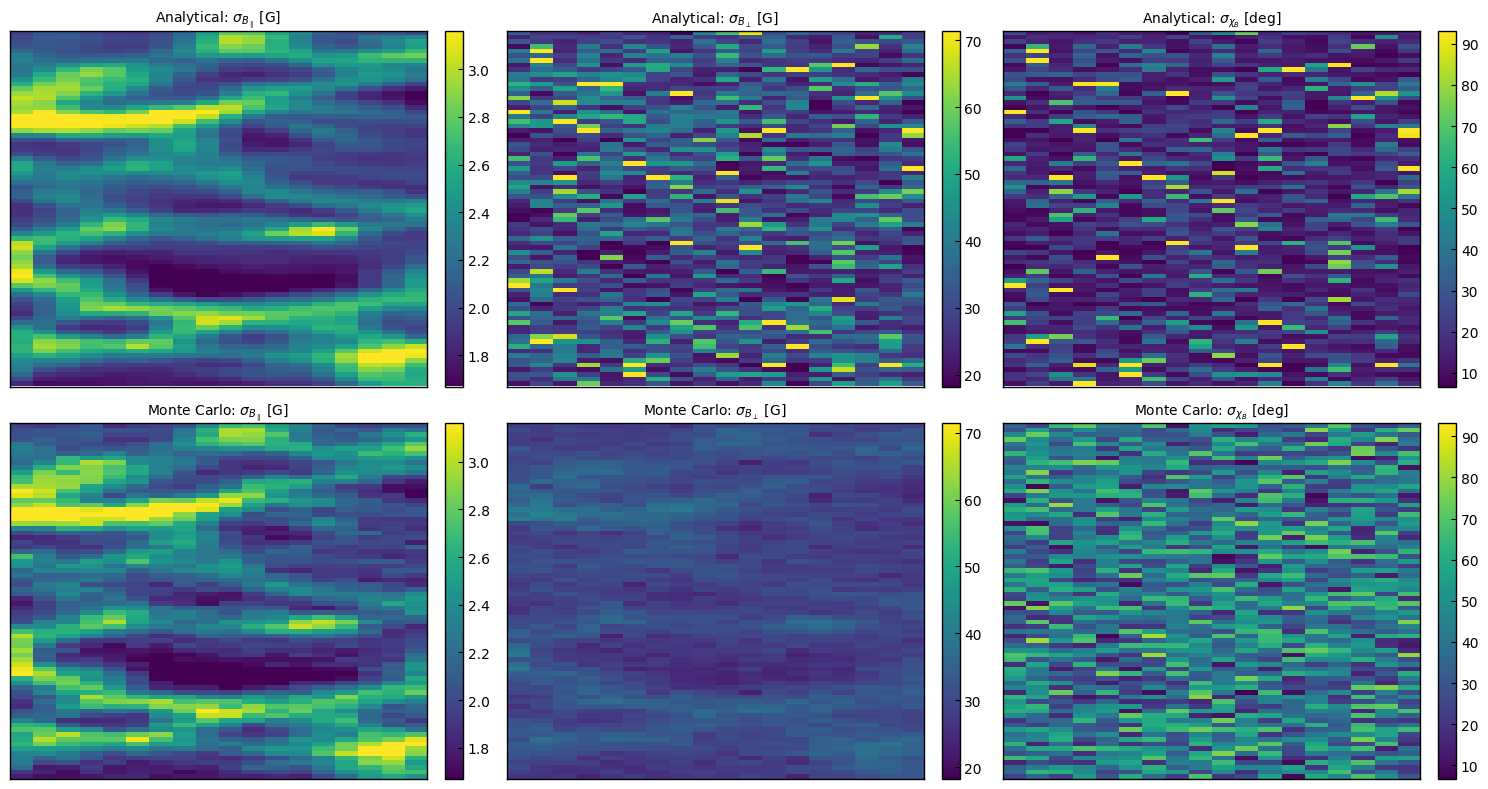

B_parallel
Analytical mean: 2.266
Monte Carlo mean: 2.259
Relative difference: -0.3%
B_perp
Analytical mean: 33.589
Monte Carlo mean: 30.242
Relative difference: -10.0%
chi_B
Analytical mean: 24.909
Monte Carlo mean: 41.744
Relative difference: +67.6%


In [23]:
# Compare analytical vs Monte Carlo uncertainties
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

t_compare = 5

comparison_data = [
    (sigma_B_los, mc_wfa_results['B_los_std'], r'$\sigma_{B_\parallel}$ [G]', 'B_parallel'),
    (sigma_B_trans, mc_wfa_results['B_trans_std'], r'$\sigma_{B_\perp}$ [G]', 'B_perp'),
    (sigma_chi_B_deg, np.rad2deg(mc_wfa_results['chi_B_std']), r'$\sigma_{\chi_B}$ [deg]', 'chi_B')
]

for col, (analytical, monte_carlo, label, name) in enumerate(comparison_data):
    ax_ana = axes[0, col]
    ax_mc = axes[1, col]
    
    vmin = np.nanpercentile(analytical[t_compare], 2)
    vmax = np.nanpercentile(analytical[t_compare], 98)
    
    # Analytical uncertainty map
    im_ana = ax_ana.imshow(analytical[t_compare].T, origin='lower', 
                           cmap='viridis', vmin=vmin, vmax=vmax, aspect='auto')
    ax_ana.set_title(f'Analytical: {label}', fontsize=10)
    ax_ana.set_xticks([])
    ax_ana.set_yticks([])
    plt.colorbar(im_ana, ax=ax_ana, fraction=0.046, pad=0.04)
    
    # Monte Carlo uncertainty map
    im_mc = ax_mc.imshow(monte_carlo[t_compare].T, origin='lower', 
                         cmap='viridis', vmin=vmin, vmax=vmax, aspect='auto')
    ax_mc.set_title(f'Monte Carlo: {label}', fontsize=10)
    ax_mc.set_xticks([])
    ax_mc.set_yticks([])
    plt.colorbar(im_mc, ax=ax_mc, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

for analytical, monte_carlo, label, name in comparison_data:
    ana_mean = np.nanmean(analytical[t_compare])
    mc_mean = np.nanmean(monte_carlo[t_compare])
    rel_diff = 100 * (mc_mean - ana_mean) / ana_mean
    
    print('=====================')
    print(name)
    print('=====================')
    print(f'Analytical mean: {ana_mean:.3f}')
    print(f'Monte Carlo mean: {mc_mean:.3f}')
    print(f'Relative difference: {rel_diff:+.1f}%')

### Comparison between analytical and Monte Carlo error estimators

The Monte Carlo approach provides empirical uncertainty estimates by directly simulating the effect of noise on the WFA inversion. This method generates multiple realizations of the observed Stokes profiles with added Gaussian noise at the measured continuum level, then applies the WFA to each realization to build statistical distributions of the inferred magnetic field parameters.

The comparison reveals generally good agreement between Monte Carlo uncertainties and analytical error propagation formulas, thereby validating both approaches. Small differences arise because the analytical formulas employ linearized approximations whereas Monte Carlo captures the full nonlinear response of the WFA equations to noise perturbations. In regions with strong polarization signals, both methods converge to nearly identical uncertainty estimates, while in weak-field regions the Monte Carlo approach tends to yield slightly larger uncertainties due to its explicit treatment of nonlinear effects.

Regarding bias estimation, the two methods differ in implementation. The Monte Carlo method directly measures the systematic positive bias in $B_\perp$ through the difference between the median and lower percentile of the distribution, reflecting the asymmetry introduced by the non-negativity constraint and fourth-root dependence. The analytical approach instead requires an explicit bias correction term derived from theoretical considerations. Both approaches yield consistent bias estimates of order 20-30 G in weak-field regions for the present observational noise level.

For this analysis, the analytical uncertainties prove sufficient and appropriate. The Monte Carlo validation confirms their reliability across the full range of field strengths and geometries present in the observed flux emergence region. The close agreement between methods provides confidence in the reported uncertainty estimates and validates the simplified analytical approach for routine WFA applications.

# 5. Discussion and Critical Analysis

The inferred magnetic field maps reveal the characteristic bipolar structure of an emerging flux region. The longitudinal component $B_\parallel$ shows positive and negative polarities corresponding to field lines emerging from one photospheric footpoint and returning at another. The transverse component $B_\perp$ exhibits enhancement in the region connecting the two polarities, consistent with the loop-like topology expected in flux emergence scenarios.

The azimuth maps display non-homogeneous values, as physically expected for a curved magnetic structure. In a flux emergence event, the magnetic field forms loop-like configurations where field lines emerge approximately vertically at the footpoints, where $B_\perp \approx 0$ and azimuth becomes ill-defined, then bend to form horizontal connections between polarities where $B_\perp$ dominates and azimuth becomes well-defined.

Given the polarization reference frame where $\chi = 0°$ is parallel to the scan direction and increases counter-clockwise, we can interpret the azimuth distribution. In regions with strong transverse field, the azimuth traces the projected magnetic field orientation in the plane of the sky. For a loop connecting polarities along the X-direction, we expect azimuth values around $\pm 90°$, perpendicular to the scan direction. In regions with weak transverse field near the footpoints, the azimuth becomes unreliable, as evidenced by the high $\sigma_{\chi_B}$ values. This behavior is consistent with our Monte Carlo findings that azimuth determination fails when the transverse field approaches the noise level.

The observed spatial variation in azimuth aligns with the expected geometry of a curved magnetic loop rather than a uniform field configuration, providing physical validation of the inferred field topology.

Based on the systematic noise characterization performed in Section 4.3, with observational noise level $\sigma \approx 1.7 \times 10^{-3}$ measured from continuum windows, we can assess the reliability of different magnetic field components. The line-of-sight component $B_\parallel$ shows robust recovery with minimal systematic bias at our noise level. The linear relationship between Stokes V and $B_\parallel$ provides inherent stability, and the inferred values should be trustworthy across the entire field of view.

The transverse component $B_\perp$ presents greater challenges due to larger uncertainties and potential positive bias, particularly in weak-field regions. The systematic bias term $\Delta B_\perp \approx \sqrt{\sigma_P} (2/\sum I''I'')^{1/4} / C_0$ introduces overestimation arising from the fourth-root dependence and non-negativity constraint. Values of $B_\perp$ below approximately 50 G should be interpreted with caution as they may be dominated by this noise-induced bias rather than representing true magnetic field strengths.

The azimuth $\chi_B$ requires the most careful interpretation. Our Monte Carlo study in Section 4.4 demonstrated that azimuth determination becomes unreliable when $B_\perp$ approaches the noise floor, since azimuth depends on the ratio of Stokes U to Q which becomes ill-defined at low signal-to-noise. The uncertainty maps correctly identify these problematic regions through high $\sigma_{\chi_B}$ values. Only regions satisfying $B_\perp \gg 50$ G and $\sigma_{\chi_B} < 30°$ should be considered reliable for geometric interpretation of field orientation.

An important validation comes from spatial coherence. The azimuth shows coherent spatial patterns in regions with strong $B_\perp$ rather than random noise, providing confidence that we are indeed detecting the magnetic field geometry in those areas. This coherence would not emerge if the measurements were noise-dominated, supporting the physical interpretation of the inferred field configuration.


# 6. Conclusion

The Weak Field Approximation successfully recovers the magnetic field structure in the flux emergence region within the expected limitations established by synthetic testing. The non-homogeneous azimuth distribution is physically consistent with a curved loop topology characteristic of emerging magnetic flux. The reliability hierarchy $B_\parallel > B_\perp > \chi_B$ in terms of noise tolerance, established through systematic Monte Carlo characterization in Section 4.3, is clearly reflected in the uncertainty maps of the actual observations, validating the predictive power of the synthetic noise analysis.